In [46]:
import pandas as pd
import wrds
import numpy as np
import matplotlib.pyplot as plt

db = wrds.Connection(wrds_username='elsalundblad')

Loading library list...
Done


In [48]:
# Import data from 
df = db.raw_sql("""
                    select secd.datadate, secd.isin, secd.conm, 
                           secd.prccd, secd.ajexdi, secd.trfd, 
                           secd.cshoc, secd.gind, secd.gvkey
                    from comp_global_daily.g_secd as secd
                    WHERE secd.exchg = '194'
                    AND secd.fic = 'GBR'
                    AND secd.curcdd = 'GBP'
                    AND secd.isin IS NOT NULL
                    AND secd.datadate >='2020-01-01'
                    AND secd.isin IN (
                        SELECT isin 
                        FROM comp_global_daily.g_secd
                        GROUP BY isin
                        HAVING COUNT(*) > 500
                    )
                    """,
                    date_cols=['datadate'])

df = df.set_index(['isin','datadate'])

print(df)

                                               conm   prccd  ajexdi  \
isin         datadate                                                 
GB0002875804 2020-01-01    BRITISH AMER TOBACCO PLC  32.315     1.0   
             2020-01-02    BRITISH AMER TOBACCO PLC  32.650     1.0   
             2020-01-03    BRITISH AMER TOBACCO PLC  33.520     1.0   
             2020-01-06    BRITISH AMER TOBACCO PLC  33.500     1.0   
             2020-01-07    BRITISH AMER TOBACCO PLC  34.060     1.0   
...                                             ...     ...     ...   
GB00B1DQ6472 2025-01-09  GLOBAL EQUITY INCOME SHARE   3.060     1.0   
             2025-01-10  GLOBAL EQUITY INCOME SHARE   3.040     1.0   
             2025-01-13  GLOBAL EQUITY INCOME SHARE   3.040     1.0   
             2025-01-14  GLOBAL EQUITY INCOME SHARE   3.060     1.0   
             2025-01-15  GLOBAL EQUITY INCOME SHARE   3.100     1.0   

                              trfd         cshoc    gind   gvkey  
isin     

**Daily Returns**

In [50]:
# Calculate the adjusted close price (PRCCD / AJEXDI)
df['adj_close'] = df['prccd'] / df['ajexdi']

# Calculate the Market Capitalization
df["mktcap"] = df["prccd"] * df["cshoc"]

# Calculate daily returns
# (((((PRCCD/AJEXDI)*TRFD) /((PRCCD(PRIOR)/AJEXDI(PRIOR))*TRFD(PRIOR))) -1 )* 100).
df['daily_return'] = df.groupby(level=0).apply(
    lambda group: ((group['adj_close'] * group['trfd']) / 
                   (group['adj_close'].shift(1) * group['trfd'].shift(1)) - 1)).droplevel(0)

# Compute the weighted return (daily_return * mktcap)
df['weighted_return'] = df['daily_return'] * df['mktcap']

df = df[['conm', 'gind', 'adj_close', 'daily_return', 'weighted_return', 'mktcap']]
print(df)

                                               conm    gind  adj_close  \
isin         datadate                                                    
GB0002875804 2020-01-01    BRITISH AMER TOBACCO PLC  302030     32.315   
             2020-01-02    BRITISH AMER TOBACCO PLC  302030     32.650   
             2020-01-03    BRITISH AMER TOBACCO PLC  302030     33.520   
             2020-01-06    BRITISH AMER TOBACCO PLC  302030     33.500   
             2020-01-07    BRITISH AMER TOBACCO PLC  302030     34.060   
...                                             ...     ...        ...   
GB00B1DQ6472 2025-01-09  GLOBAL EQUITY INCOME SHARE    None      3.060   
             2025-01-10  GLOBAL EQUITY INCOME SHARE    None      3.040   
             2025-01-13  GLOBAL EQUITY INCOME SHARE    None      3.040   
             2025-01-14  GLOBAL EQUITY INCOME SHARE    None      3.060   
             2025-01-15  GLOBAL EQUITY INCOME SHARE    None      3.100   

                         daily_return

**Weighted Cumulative Returns**

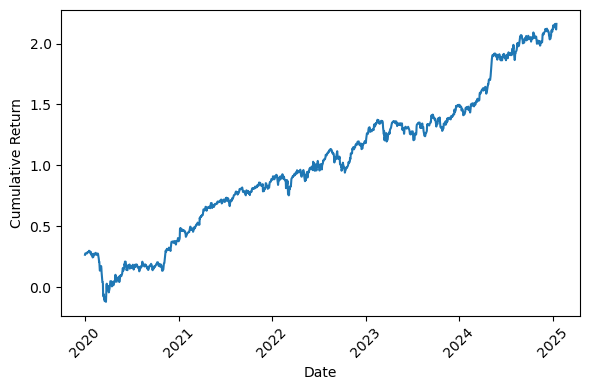

In [52]:
# Group by 'datadate' to compute the aggregated weighted average return across all companies
aggregated_returns = df.groupby('datadate').apply(
    lambda group: group['weighted_return'].sum() / group['mktcap'].sum()
).reset_index(name='aggregated_weighted_return')

# Compute the cumulative return across all companies
aggregated_returns['cumulative_return'] = (1 + aggregated_returns['aggregated_weighted_return']).cumprod() - 1

# Plotting the aggregated cumulative returns over time
plt.figure(figsize=(6, 4))

plt.plot(aggregated_returns['datadate'], aggregated_returns['cumulative_return'], label='All Companies')

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plot24.pdf", format="pdf", bbox_inches="tight")

plt.show()

**Industry Portfolios**

In [56]:
# Create a dictionary for the mappings
industry_mapping = {
    '10': 'Energy',
    '15': 'Materials',
    '20': 'Industrials',
    '25': 'Consumer Discretionary',
    '30': 'Consumer Staples',
    '35': 'Health Care',
    '40': 'Financials',
    '45': 'Information Technology',
    '55': 'Utilities'
}

# Extract the first two digits of 'gind' and map them to the industry
df['sector'] = df['gind'].astype(str).str[:2].map(industry_mapping)
df.dropna()

conm    gind  adj_close  \
isin         datadate                                                  
GB0002875804 2020-01-02  BRITISH AMER TOBACCO PLC  302030   32.65000   
             2020-01-03  BRITISH AMER TOBACCO PLC  302030   33.52000   
             2020-01-06  BRITISH AMER TOBACCO PLC  302030   33.50000   
             2020-01-07  BRITISH AMER TOBACCO PLC  302030   34.06000   
             2020-01-08  BRITISH AMER TOBACCO PLC  302030   34.69500   
...                                           ...     ...        ...   
GB00BPCPPZ79 2025-01-09        FULCRUM METALS PLC  151040    0.07875   
             2025-01-10        FULCRUM METALS PLC  151040    0.07875   
             2025-01-13        FULCRUM METALS PLC  151040    0.07875   
             2025-01-14        FULCRUM METALS PLC  151040    0.07875   
             2025-01-15        FULCRUM METALS PLC  151040    0.07875   

                         daily_return  weighted_return        mktcap  \
isin         datadate                                                  
GB0002875804 2020-01-02      0.010367     7.764144e+08  7.489502e+10   
             2020-01-03      0.026646     2.048849e+09  7.689069e+10   
             2020-01-06     -0.000597    -4.585013e+07  7.684482e+10   
             2020-01-07      0.016716     1.306043e+09  7.812939e+10   
             2020-01-08      0.018644     1.483767e+09  7.958600e+10   
...                               ...              ...           ...   
GB00BPCPPZ79 2025-01-09      0.000000     0.000000e+00  4.868793e+06   
             2025-01-10      0.000000     0.000000e+00  4.868793e+06   
             2025-01-13      0.000000     0.000000e+00  4.868793e+06   
             2025-01-14      0.000000     0.000000e+00  4.868793e+06   
             2025-01-15      0.000000     0.000000e+00  4.868793e+06   

                                   sector  
isin         datadate                      
GB0002875804 2020-01-02  Consumer Staples  
             2020-01-03  Consumer Staples  
             2020-01-06  Consumer Staples  
             2020-01-07  Consumer Staples  
             2020-01-08  Consumer Staples  
...                                   ...  
GB00BPCPPZ79 2025-01-09         Materials  
             2025-01-10         Materials  
             2025-01-13         Materials  
             2025-01-14         Materials  
             2025-01-15         Materials  

[1339894 rows x 7 columns]

/var/folders/7n/lxgb121j7m54bx6fcdxysh6w0000gn/T/ipykernel_65909/3870647441.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_daily_returns = df.groupby(['datadate', 'sector']).apply(


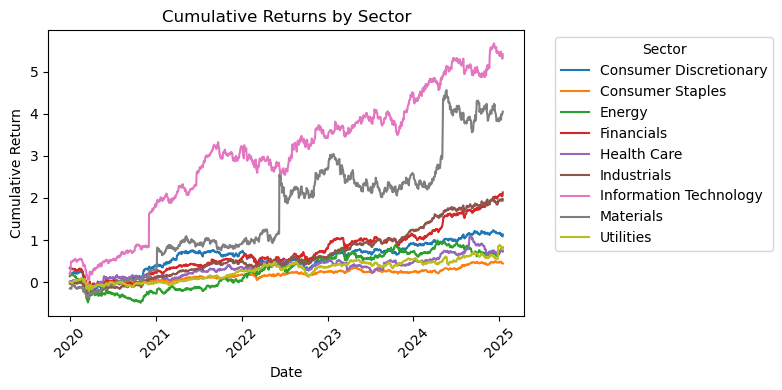

In [58]:
# Group by 'datadate' and 'sector' to compute the weighted average return per sector
weighted_daily_returns = df.groupby(['datadate', 'sector']).apply(
    lambda group: group['weighted_return'].sum() / group['mktcap'].sum()
).reset_index(name='sector_weighted_daily_return')

# Compute the cumulative return for each sector independently
# We ensure the result has the correct index after applying the cumulative product
weighted_daily_returns['cumulative_return'] = weighted_daily_returns.groupby('sector')['sector_weighted_daily_return'].transform(
    lambda x: (1 + x).cumprod() - 1
)

plt.figure(figsize=(8, 4))

for sector in weighted_daily_returns['sector'].unique():
    sector_data = weighted_daily_returns[weighted_daily_returns['sector'] == sector]
    plt.plot(sector_data['datadate'], sector_data['cumulative_return'], label=sector)

plt.title('Cumulative Returns by Sector')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()